In [1]:
# import packages
import numpy as np
import jax.scipy as jsp # boost computation
import matplotlib.pyplot as plt
import imageio
from os import listdir

In [2]:
# interactive plotting
#%matplotlib notebook
%matplotlib inline

In [3]:
def imread_batch(folder, mode = 'Stack', fname_spec = None):
    '''
    Batch import static images, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of filenames
    if fname_spec == None:
        # assume all files in folder are images
        fnames = sorted(listdir(folder))
    else:
        fnames = list(fname for fname in sorted(listdir(folder)) if fname_spec in fname)
        if len(fnames) == 0:
            print('Error: No file name contains ' + str(fname_spec))
            return

    # determine the dimensions of each image
    temp = imageio.imread(folder + fnames[0])
    idx = temp.shape
    img_num = len(fnames)
  
    # initialize
    img_temp = np.zeros((idx[0]*idx[1], img_num))
    for i in range(img_num):
        # assume the image is in grayscale
        img = imageio.imread(folder + fnames[i])
        img = img.reshape(idx[0]*idx[1])
        img_temp[:,i] = img
    
    # Average mode
    if mode == 'Avg':
        img_data = np.zeros((idx[0]*idx[1], 1))
        img_data[:,0] = img_temp.mean(axis = 1)
    # Stack mode
    elif mode == 'Stack':
        img_data = img_temp
    
    return img_data   

In [4]:
def imread_batch_multidir(folder, mode = 'Stack', fname_spec = None, dirname_spec = None):
    '''
    Batch import static images from multiple directories in folder, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
        dirname_spec: (String) specify what is contained in directory name
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of directory names
    if dirname_spec == None:
        # assume all items in folder are directories
        dirnames = sorted(listdir(folder))
    else:
        dirnames = list(dirname for dirname in sorted(listdir(folder)) if dirname_spec in dirname)
        if len(dirnames) == 0:
            print('Error: No directory name contains ' + str(dirname_spec))
            return
    
    # avoid ambiguity when passing arguments
    str1, str2 = mode, fname_spec
    
    # Batch import images in each folder
    img_data = imread_batch(folder + dirnames[0], mode = str1, fname_spec = str2)
    for i in range(1, len(dirnames)):
        data = imread_batch(folder + dirnames[i], mode = str1, fname_spec = str2)
        img_data = np.concatenate((img_data, data), axis = 1)
    
    return img_data

In [5]:
#! unzip /content/drive/MyDrive/Study/AMATH_584/yalefaces_cropped.zip 

In [6]:
!ls


CroppedYale  drive  __MACOSX  sample_data


In [7]:
img_crop = imread_batch_multidir('CroppedYale/', mode = 'Stack', dirname_spec = 'yale')

In [8]:
img_crop.shape #192*268*2432

(32256, 2432)

In [9]:
img_crop_sample = img_crop[:,0:35]

In [10]:
%%time
u_crop_fast, s_crop_fast, vh_crop_fast = jsp.linalg.svd(img_crop_sample, full_matrices = False)

CPU times: user 185 ms, sys: 25.5 ms, total: 210 ms
Wall time: 556 ms


In [11]:
print(u_crop_fast.shape)
print(s_crop_fast.shape)
print(vh_crop_fast.shape)

(32256, 35)
(35,)
(35, 35)


In [12]:
%%time
u_crop = np.asarray(u_crop_fast)
s_crop = np.asarray(s_crop_fast)
vh_crop = np.asarray(vh_crop_fast)

CPU times: user 32.2 ms, sys: 8.05 ms, total: 40.3 ms
Wall time: 38.8 ms


In [13]:
def power_iterate(A):
    n1 = A.shape[0]
    n2 = A.shape[1]
    v=np.random.randn(n1,1)
    lambda_max = np.inf
    tol = 1e-5
    lambdaold = 1
    lambda_ite=[]
    
    while abs(lambda_max-lambdaold) > tol:
        lambdaold = lambda_max
        vnew = np.dot(A,v)
        v = vnew/np.linalg.norm(vnew)
        #print(v.shape)
        lambda_max = np.dot(np.dot(v.T,A),v)
        #print(lambda_max)
        lambda_ite.append(lambda_max)
    return lambda_ite, v

In [14]:
%%time 

ima = np.dot(img_crop_sample[:,:],img_crop_sample[:,:].T)

CPU times: user 7.25 s, sys: 1.38 s, total: 8.62 s
Wall time: 5.23 s


In [15]:
max_lambda_ite_2, max_vec_v2 = power_iterate(ima)

In [16]:
print("power iterate: " + str(np.sqrt(max_lambda_ite_2[-1])))
print("SVD dominant eigenvalue: " + str(np.max(s_crop)))

power iterate: [[94051.27025262]]
SVD dominant eigenvalue: 94051.25


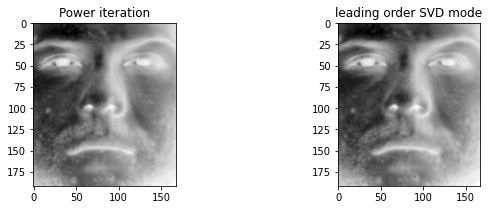

In [32]:
plt.figure(2, figsize = (10,3))
plt.subplot(1,2,1)
plt.imshow((max_vec_v2[:,0]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Power iteration')

plt.subplot(1,2,2)
plt.imshow((u_crop_fast[:,0]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('leading order SVD mode')
plt.savefig('HW5_Q2_1a.png',dpi=200)

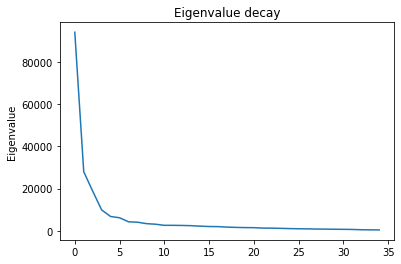

In [34]:
plt.plot(s_crop)
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue decay')
plt.savefig('HW5_Q2_1b_1.png',dpi=200)

In [19]:
## b) randomized sampling to reproduce the SVD 

In [43]:
#stage a
M = img_crop_sample.shape[0]
N = img_crop_sample.shape[1]
K = 10
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U, S, V = jsp.linalg.svd(B, full_matrices = False)
uapprox=np.dot(Q,U)

(32256, 10)


In [44]:
S

DeviceArray([93952.586 , 27747.379 , 18161.434 ,  8818.591 ,  5539.1597,
              4948.2246,  3493.63  ,  3253.4575,  2514.5513,  2296.5652],            dtype=float32)

In [45]:
s_crop

array([94051.25   , 27951.264  , 18769.914  ,  9855.73   ,  6747.169  ,
        6158.261  ,  4244.217  ,  4051.1821 ,  3368.7874 ,  3101.134  ,
        2573.2786 ,  2567.341  ,  2510.5437 ,  2402.4907 ,  2179.662  ,
        2005.2959 ,  1956.9631 ,  1734.9985 ,  1589.7467 ,  1499.1857 ,
        1459.6212 ,  1259.3497 ,  1233.15   ,  1133.3706 ,  1019.0737 ,
         946.5928 ,   884.27747,   806.6159 ,   767.6254 ,   705.02954,
         673.08575,   617.1363 ,   474.54288,   432.90335,   394.26035],
      dtype=float32)

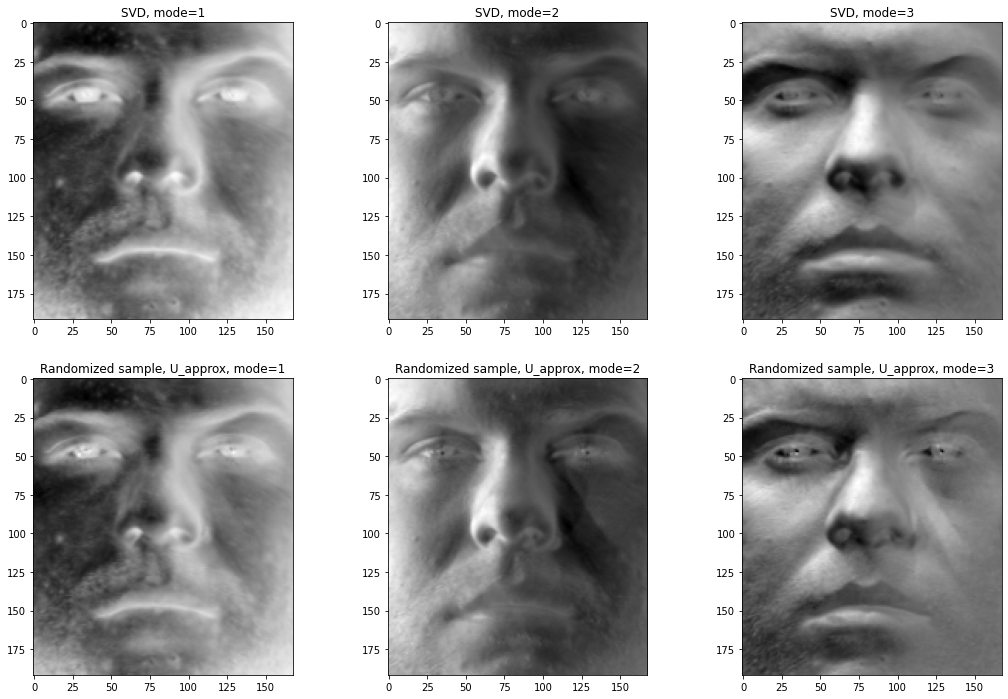

In [47]:
plt.figure(figsize = (18,12))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow((u_crop_fast[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('SVD, mode='+str(i+1))

for i in range(3):
  plt.subplot(2,3,i+4)
  plt.imshow((uapprox[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, U_approx, mode='+str(i+1))
plt.savefig('HW5_Q2_1b_2.png',dpi=200)


In [24]:
## c) as a function of the number of randomized samples 

In [60]:
#stage a
K = 5
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U1, S1, V1 = jsp.linalg.svd(B, full_matrices = False)
uapprox1=np.dot(Q,U1)

(32256, 5)


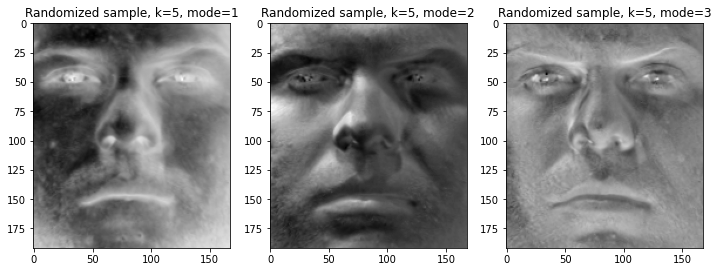

In [63]:
plt.figure(figsize = (12,18))

for i in range(3):
  plt.subplot(3,3,i+1)
  plt.imshow((uapprox1[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, k=5, mode='+str(i+1))

(32256, 10)


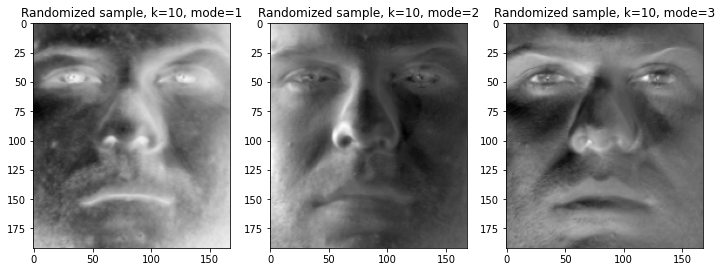

In [70]:
K = 10
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U2, S2, V2 = jsp.linalg.svd(B, full_matrices = False)
uapprox2=np.dot(Q,U2)

plt.figure(figsize = (12,18))

for i in range(3):
  plt.subplot(3,3,i+1)
  plt.imshow((uapprox2[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, k=10, mode='+str(i+1))

(32256, 15)


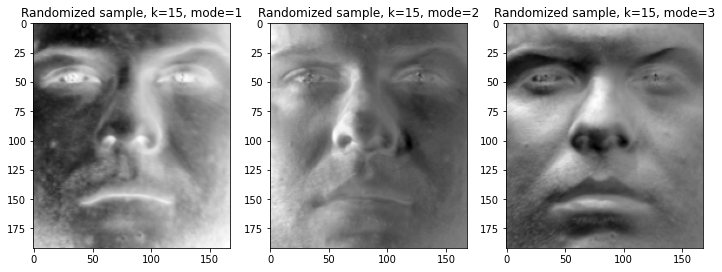

In [78]:
K = 15
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U3, S3, V3 = jsp.linalg.svd(B, full_matrices = False)
uapprox3=np.dot(Q,U3)

plt.figure(figsize = (12,18))
for i in range(3):
  plt.subplot(3,3,i+1)
  plt.imshow((uapprox3[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, k=15, mode='+str(i+1))

(32256, 20)


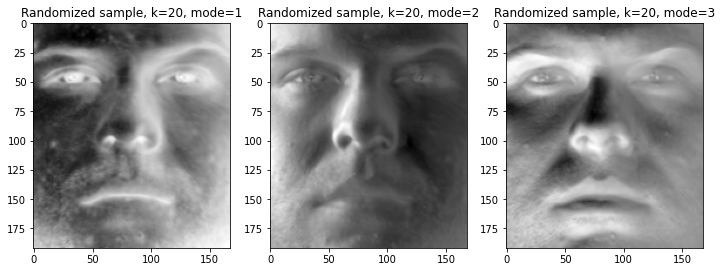

In [79]:
K = 20
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U4, S4, V4 = jsp.linalg.svd(B, full_matrices = False)
uapprox4=np.dot(Q,U4)

plt.figure(figsize = (12,18))
for i in range(3):
  plt.subplot(3,3,i+1)
  plt.imshow((uapprox4[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, k=20, mode='+str(i+1))

(32256, 25)


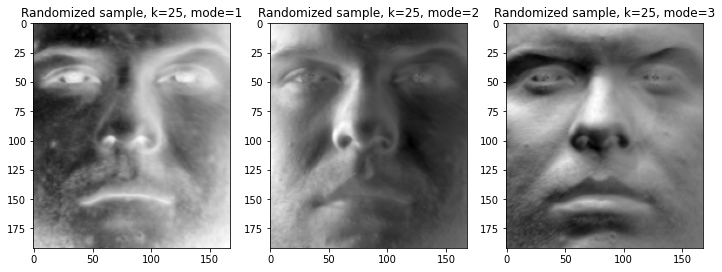

In [80]:
K = 25
Omega = np.random.randn(N,K)
Y=np.dot(img_crop_sample,Omega)
[Q,R] = np.linalg.qr(Y)
print(Q.shape)

#stage B
B = np.dot(Q.T,img_crop_sample)
U5, S5, V5 = jsp.linalg.svd(B, full_matrices = False)
uapprox5=np.dot(Q,U5)

plt.figure(figsize = (12,18))
for i in range(3):
  plt.subplot(3,3,i+1)
  plt.imshow((uapprox5[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('Randomized sample, k=25, mode='+str(i+1))

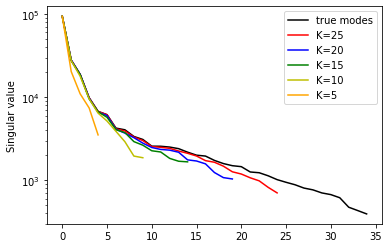

In [87]:
plt.plot(s_crop,c='k',label='true modes')
plt.plot(S5,c='r',label='K=25')
plt.plot(S4,c='b',label='K=20')
plt.plot(S3,c='g',label='K=15')
plt.plot(S2,c='y',label='K=10')
plt.plot(S1,c='orange',label='K=5')
plt.legend()
plt.yscale('log')
plt.ylabel('Singular value')
plt.savefig('HW5_Q2_1c_1.png',dpi=200)

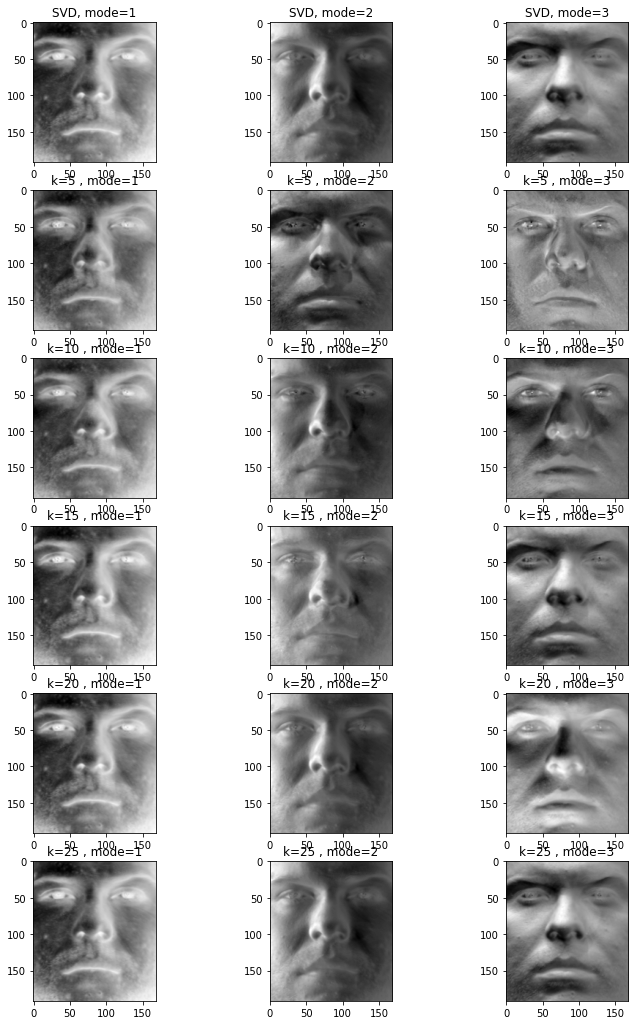

In [89]:
plt.figure(figsize = (12,18))

for i in range(3):
  plt.subplot(6,3,i+1)
  plt.imshow((u_crop_fast[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('SVD, mode='+str(i+1))

for i in range(3):
  plt.subplot(6,3,i+4)
  plt.imshow((uapprox1[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('k=5 , mode='+str(i+1))

for i in range(3):
  plt.subplot(6,3,i+7)
  plt.imshow((uapprox2[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('k=10 , mode='+str(i+1))


for i in range(3):
  plt.subplot(6,3,i+10)
  plt.imshow((uapprox3[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('k=15 , mode='+str(i+1))

for i in range(3):
  plt.subplot(6,3,i+13)
  plt.imshow((uapprox4[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('k=20 , mode='+str(i+1))

for i in range(3):
  plt.subplot(6,3,i+16)
  plt.imshow((uapprox5[:,i]).reshape(192, 168), cmap = plt.get_cmap("gray"))
  plt.title('k=25 , mode='+str(i+1))
plt.savefig('HW5_Q2_1c_2.png',dpi=200)
